In [43]:
%config InlineBackend.figure_format='retina'

In [44]:
import fastbook
fastbook.setup_book()

In [45]:
from fastbook import *
from fastai.vision.core import *
from PIL import Image
from sklearn.metrics import confusion_matrix

In [46]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

In [47]:
import pandas as pd
import numpy as np

In [48]:
import torch
import torch.nn.functional as F

In [49]:
from typing import Dict

import pathlib
import random

# MNIST classifier

## loading raw images into `d_images`

In [50]:
DIR_MNIST = untar_data(URLs.MNIST)

In [51]:
(DIR_MNIST/'training').ls()

(#10) [Path('/Users/alessandrofinamore/.fastai/data/mnist_png/training/9'),Path('/Users/alessandrofinamore/.fastai/data/mnist_png/training/0'),Path('/Users/alessandrofinamore/.fastai/data/mnist_png/training/7'),Path('/Users/alessandrofinamore/.fastai/data/mnist_png/training/6'),Path('/Users/alessandrofinamore/.fastai/data/mnist_png/training/1'),Path('/Users/alessandrofinamore/.fastai/data/mnist_png/training/8'),Path('/Users/alessandrofinamore/.fastai/data/mnist_png/training/4'),Path('/Users/alessandrofinamore/.fastai/data/mnist_png/training/3'),Path('/Users/alessandrofinamore/.fastai/data/mnist_png/training/2'),Path('/Users/alessandrofinamore/.fastai/data/mnist_png/training/5')]

In [52]:
def load_folder(folder:pathlib.Path) -> Dict[int,torch.tensor]:

    d_images = {}
    for folder_digit in sorted(folder.iterdir()):
        l = [
            np.array(Image.open(fname))
            for fname in get_files(folder_digit)
        ]
        digit = int(folder_digit.name)
        d_images[digit] = torch.tensor(l).float()

    return d_images

In [53]:
d_images = load_folder(DIR_MNIST / 'training')

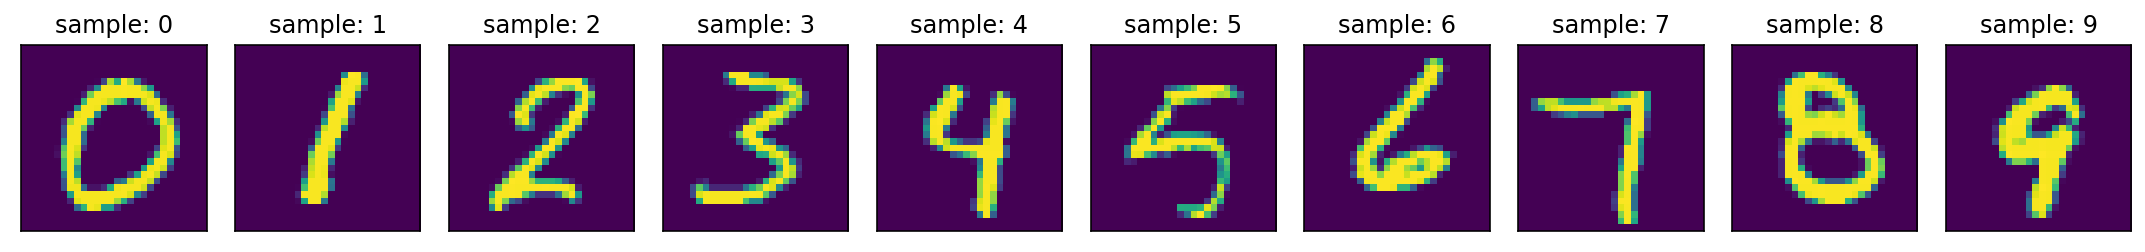

In [54]:
fig, axes = plt.subplots(nrows=1, ncols=10, figsize=(15,3))

for digit, ax in enumerate(axes):
    im = d_images[digit][0].numpy()
    ax.imshow(im)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    ax.set_title(f'sample: {digit}')
    
plt.tight_layout()

## class prototypes

### define digit "prototypes" `d_proto`

In [55]:
d_proto = {}

for digit, batch in sorted(d_images.items()):
    d_proto[digit] = batch.mean(dim=0)

In [56]:
protos = torch.stack(list(d_proto.values()))

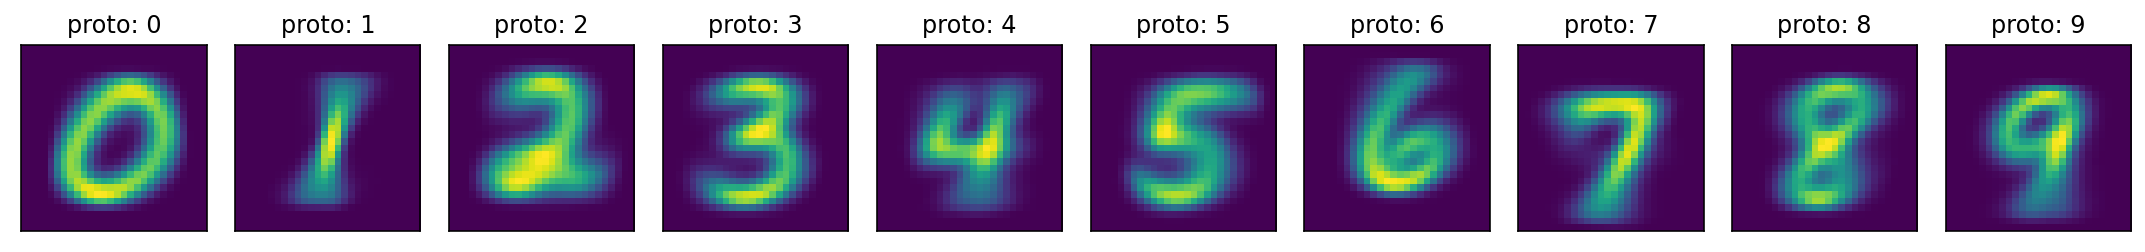

In [57]:
fig, axes = plt.subplots(nrows=1, ncols=10, figsize=(15,3))

for digit, ax in enumerate(axes):
    ax.imshow(d_proto[digit].numpy())
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    ax.set_title(f'proto: {digit}')
    
plt.tight_layout()

### classifying a random sample using prototypes

In [58]:
np.random.seed(101)
SAMPLES = 100

In [59]:
d_idx_samples = {}

for digit in range(10):
    d_idx_samples[digit] = np.random.randint(0, d_images[digit].shape[0], SAMPLES)

In [60]:
def RMSE(im1, im2):
    # use mean((-1,-2)) so to support im1 with both 2 and 3 axes
    return (im1 - im2).pow(2).mean(dim=(-1,-2)).sqrt()

In [61]:
im = d_images[3][0]

RMSE(im, d_proto[3]).item()

52.70836639404297

In [62]:
# Note: pytorch already have a function to compute MSE
# ...we just need to apply sqrt() to it
F.mse_loss(im, d_proto[3]).sqrt().item()

52.70836639404297

In [63]:
def classify(im, protos, dist_fn=RMSE):
    return dist_fn(im, protos)

In [64]:
res = []
for y_true, idx_selected in d_idx_samples.items():
    batch = d_images[y_true][idx_selected]
    for im, idx in zip(batch, idx_selected):
        loss, y_pred = classify(im, protos).min(dim=0)
        res.append((y_true, y_pred.item(), idx))

In [65]:
df_pred = pd.DataFrame(res, columns=['y_true', 'y_pred', 'idx_selected'])

In [66]:
df_pred

,y_true,y_pred,idx_selected
0,0,0,4959
1,0,0,1547
2,0,0,1361
3,0,0,5695
4,0,0,599
...,...,...,...
995,9,9,4086
996,9,9,874
997,9,9,1231
998,9,9,1053


In [67]:
conf_mtx = confusion_matrix(df_pred['y_true'], df_pred['y_pred'])

In [68]:
conf_mtx = pd.DataFrame(conf_mtx)

Text(0.5, 15.0, 'prediction')

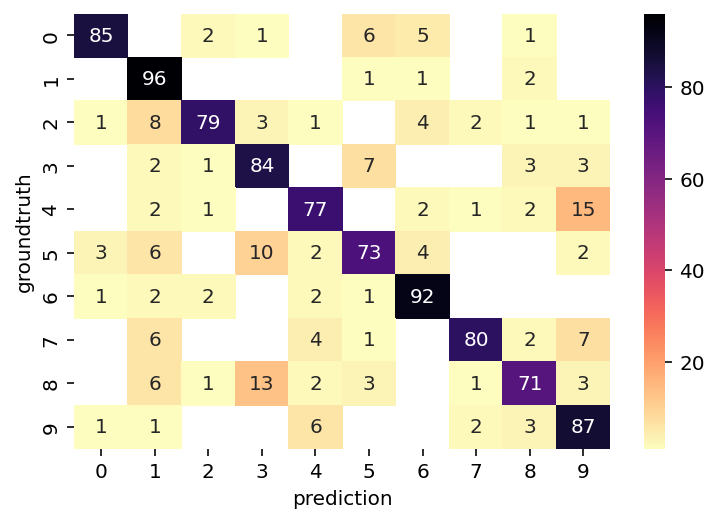

In [69]:
ax = sns.heatmap(
    data=conf_mtx.replace({0:np.nan}),
    annot=True,
    cmap='magma_r',
)
ax.set_ylabel('groundtruth')
ax.set_xlabel('prediction')

### investigate misclassifications

In [70]:
def plot_grid(df_pred, y_true, y_pred):
    df_tmp = df_pred[
        (df_pred['y_true'] == y_true) 
        & (df_pred['y_pred'] == y_pred)
    ]

    fig, axes = plt.subplots(nrows=1, ncols=df_tmp.shape[0], figsize=(15, 3))

    for ax, row in zip(axes, df_tmp.itertuples()):
        ax.imshow(d_images[row.y_true][row.idx_selected])
        ax.set_title(f'idx:{row.idx_selected}')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

    plt.tight_layout()
    
    return df_tmp

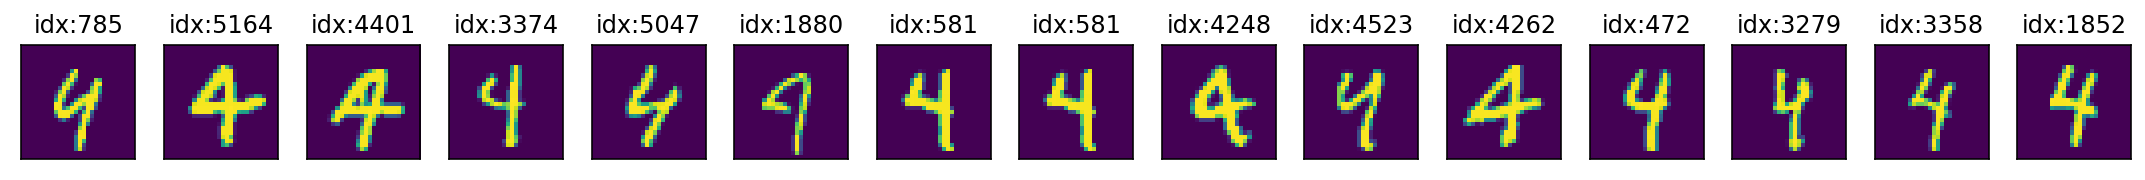

In [71]:
_ = plot_grid(df_pred, y_true=4, y_pred=9)

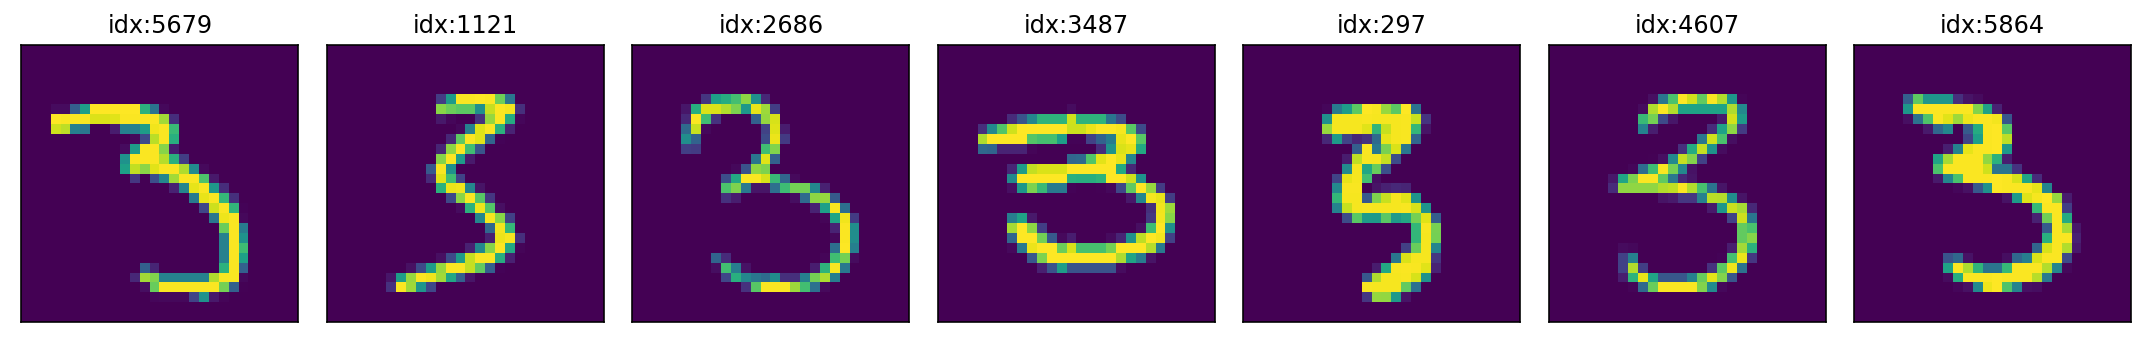

In [72]:
_ = plot_grid(df_pred, y_true=3, y_pred=5)

In [73]:
def plot_classify(y_true, idx_selected):
    im = d_images[y_true][idx_selected]
    
    pred = classify(im, protos)
    loss, y_pred = pred.min(dim=0)
    y_pred = y_pred.item()
    
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(10,3))
    
    ax = axes[0]
    pd.Series(pred.numpy()).sort_values(ascending=False).plot(
        ax=ax, 
        kind='barh', 
        rot=0
    )
    ax.set_title('distance')
    ax.set_ylabel('label')
    
    axes[1].imshow(im)
    axes[1].set_title('image')
    
    axes[2].imshow(d_proto[y_true])
    axes[2].set_title(f'expected proto: {y_true}')
    
    axes[3].imshow(d_proto[y_pred])
    axes[3].set_title(f'predicted proto: {y_pred}')
    
    plt.tight_layout()

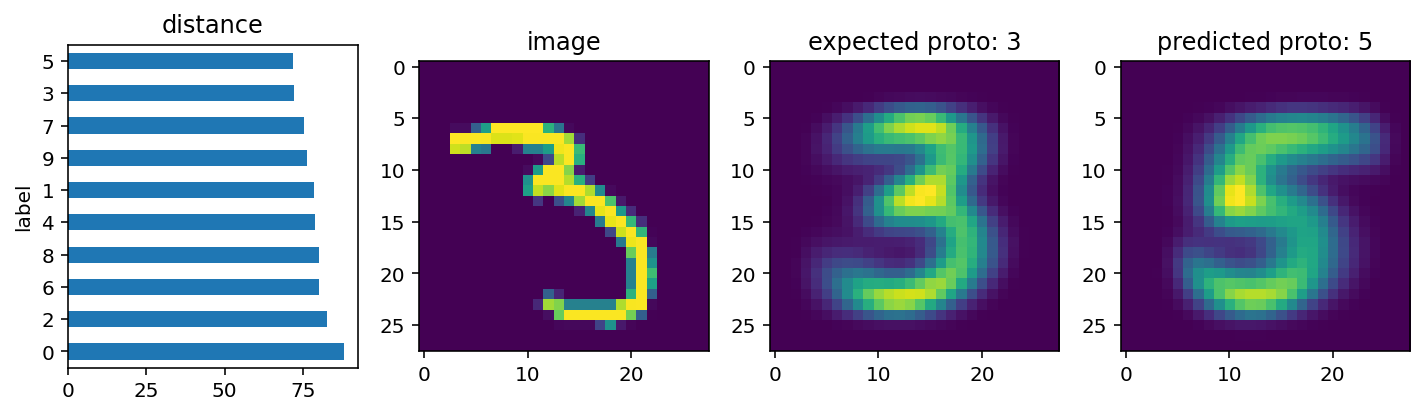

In [74]:
plot_classify(3, 5679)

### classify all images using prototypes

In [75]:
def classify_images(d_images, protos, dist_fn=RMSE):
    res = []
    labels = list(d_images.keys())
    for y_true, batch in d_images.items():
        for idx, im in enumerate(batch):
            _, y_pred = classify(im, protos, dist_fn).min(dim=0)
            y_pred = labels[y_pred.item()]
            res.append((y_true, y_pred, idx))

    df_pred = pd.DataFrame(res, columns=['y_true', 'y_pred', 'idx_selected'])
    return df_pred

In [76]:
df_pred_all = classify_images(d_images, protos)

In [77]:
def plot_conf_mtx(df_pred):
    conf_mtx = pd.DataFrame(confusion_matrix(df_pred['y_true'], df_pred['y_pred']))
    df_tmp = conf_mtx.replace({0:np.nan})
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,6))

    ax = axes[0]
    ax = sns.heatmap(
        ax=ax,
        data=df_tmp,
        annot=True,
        cmap='magma_r',
        fmt='.0f',
    )
    ax.set_xlabel('prediction')
    ax.set_ylabel('groundtruth')



    ax = axes[1]
    ax = sns.heatmap(
        ax=ax,
        data=df_tmp / df_tmp.sum(axis=1) * 100,
        annot=True,
        cmap='magma_r',
        fmt='.1f',
        vmin=0,
        vmax=100,
    )
    ax.set_xlabel('prediction')
    ax.set_ylabel('groundtruth')
    ax.set_title('Recall')

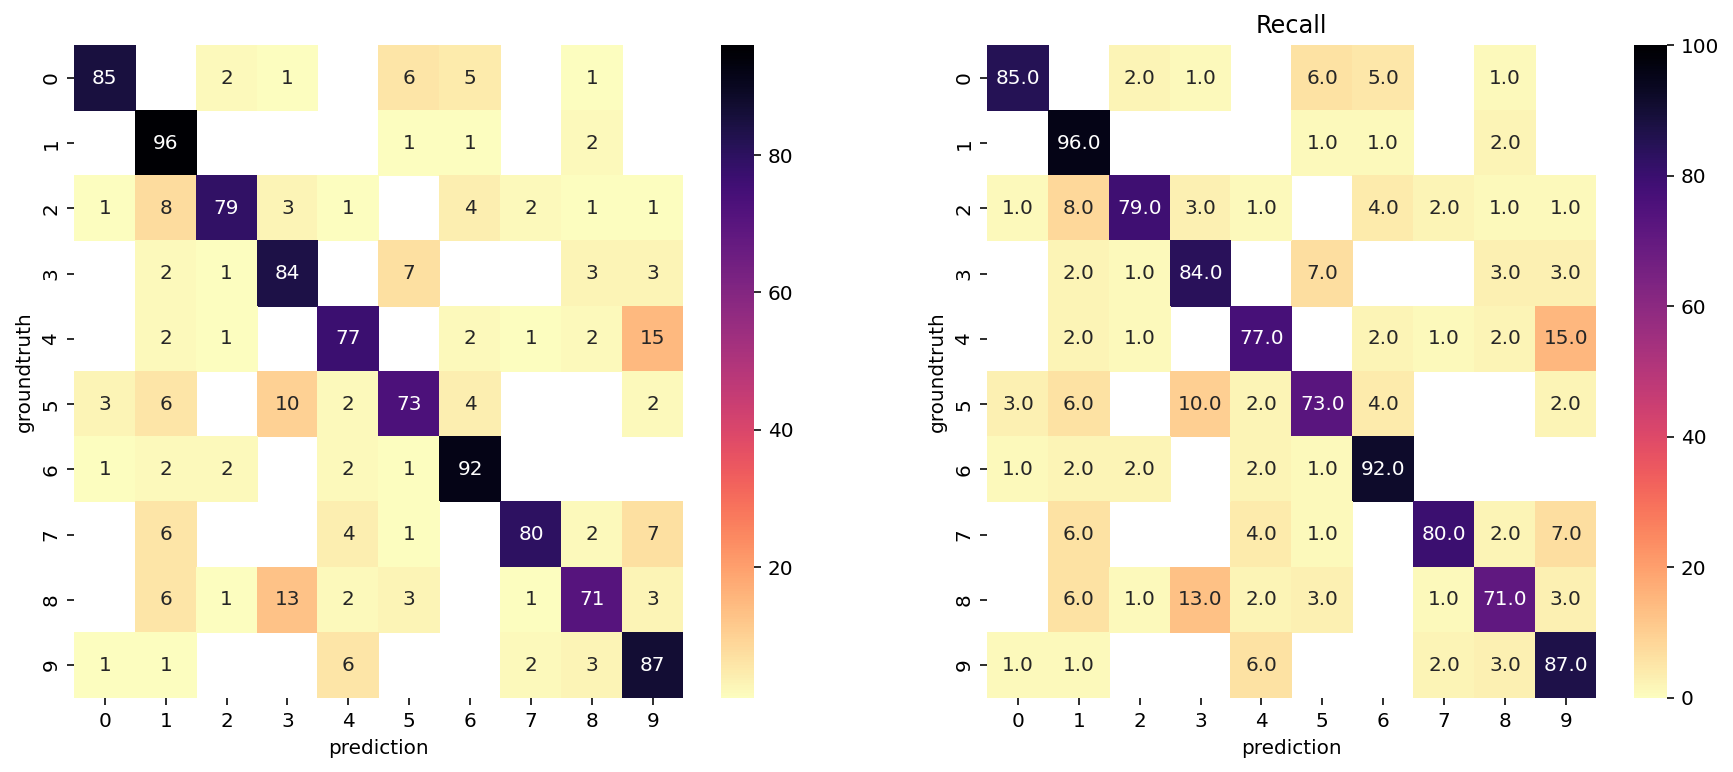

In [78]:
plot_conf_mtx(df_pred)

### classify the MNIST tes set using prototypes

In [79]:
d_images_val = load_folder(DIR_MNIST/'testing')

In [80]:
df_pred_testing = classify_images(d_images_val, protos)

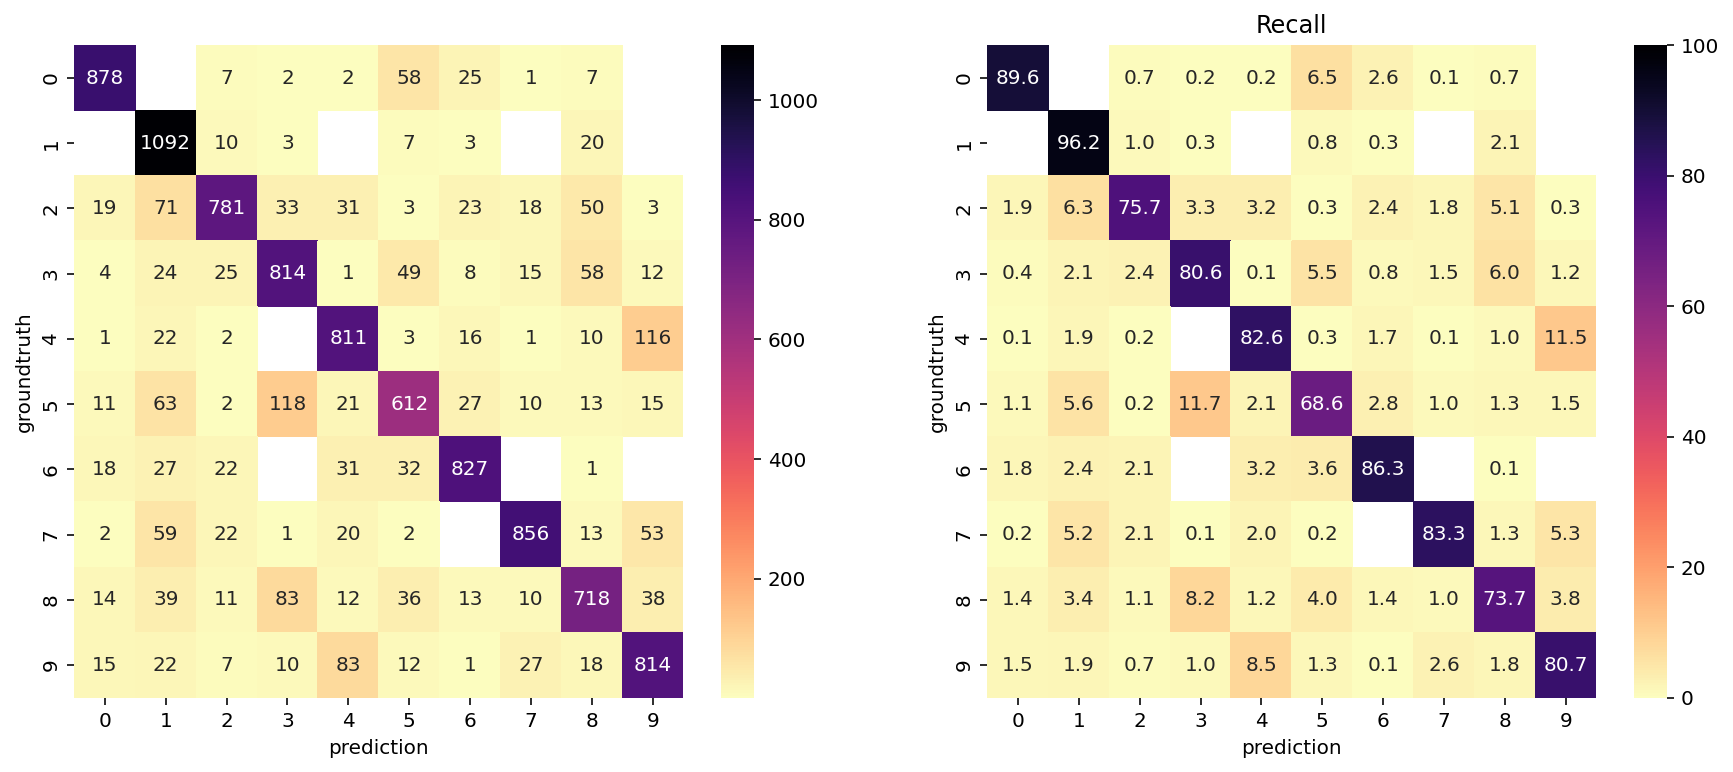

In [81]:
plot_conf_mtx(df_pred_testing)

In [82]:
correct = (df_pred_testing['y_true'] == df_pred_testing['y_pred']).sum()
print(f'Overall accuracy: {correct / df_pred_testing.shape[0] * 100:.2f}%')

Overall accuracy: 82.03%


### classifying using prototypes using only 3-and-7 classes

In [83]:
def MAE(im1, im2):
    return (im1 - im2).abs().mean((-1,-2))

In [84]:
df_pred_testing_3and7 = classify_images(
    {3:d_images_val[3], 7:d_images_val[7]},
    protos[[3,7]],
    MAE
)

In [85]:
correct = (df_pred_testing_3and7['y_true'] == df_pred_testing_3and7['y_pred']).sum()
print(f'Overall accuracy: {correct / df_pred_testing_3and7.shape[0] * 100:.2f}%')

Overall accuracy: 95.14%


In [86]:
correct = ((df_pred_testing_3and7['y_true'] == 3) & (df_pred_testing_3and7['y_pred'] == 3)).sum()
print(f'Overall accuracy: {correct / d_images_val[3].shape[0] * 100:.2f}%')

correct = ((df_pred_testing_3and7['y_true'] == 7) & (df_pred_testing_3and7['y_pred'] == 7)).sum()
print(f'Overall accuracy: {correct / d_images_val[7].shape[0] * 100:.2f}%')

Overall accuracy: 91.68%
Overall accuracy: 98.54%


# stocastic gradient descent

## parabol

In [87]:
np.random.seed(42)
torch.manual_seed(42)

In [88]:
def f(x, params):
    a,c = params
    return a*(x-10)**2 + c

In [89]:
x = torch.arange(21, dtype=np.float)

noise = torch.randint(-10, 10, size=x.shape)
params = (1, 10)
y_true = f(x, params) + noise

In [90]:
def plot_func(x, y_true, y_pred=None, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
        
    ax.scatter(x, y_true, label='f(x)')
    if y_pred is not None:
        ax.scatter(x, y_pred, label='y_pred')
    ax.legend()
    
    return ax

<AxesSubplot:>

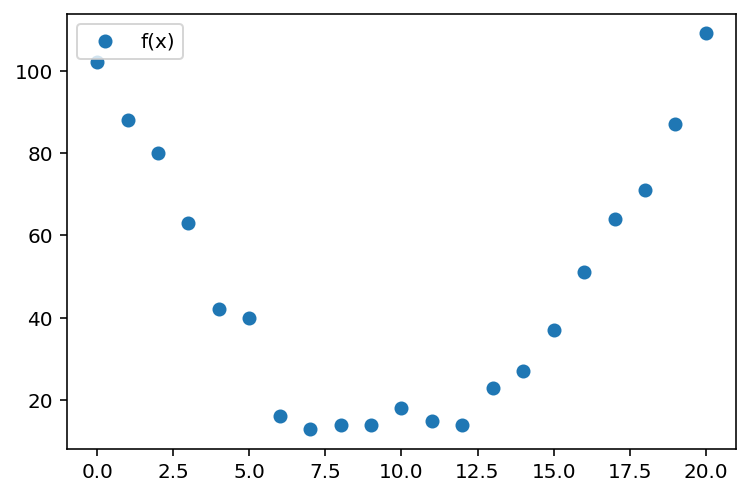

In [91]:
plot_func(x.numpy(), y_true.numpy())

In [92]:
# def loss(y_true, y_pred):
#     return (y_true - y_pred).pow(2).mean().sqrt()

In [93]:
LR = 0.01
EPOCHS = 50

In [94]:
def train_plot(x, y_true, y_pred, track_loss):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))

    plot_func(x, y_true.numpy(), y_pred.numpy(), ax=axes[0])
    
    axes[1].plot(np.arange(len(track_loss)), track_loss, label='loss')
    axes[1].legend()
    
def train(x, y_true, n_params, f, epochs, lr):
    params = torch.randn(n_params).requires_grad_()

    track_loss = []

    for _ in range(epochs): 

        y_pred = f(x, params)

        loss = (y_true - y_pred).pow(2).mean().sqrt()
        track_loss.append(loss.item())

        params.grad = None
        loss.backward()
        params.data -= lr * params.grad.data
    
    return params, track_loss

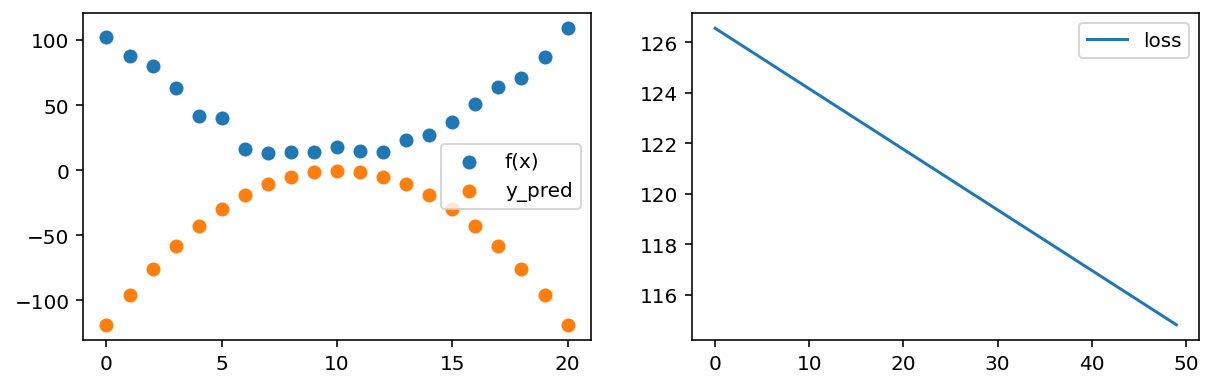

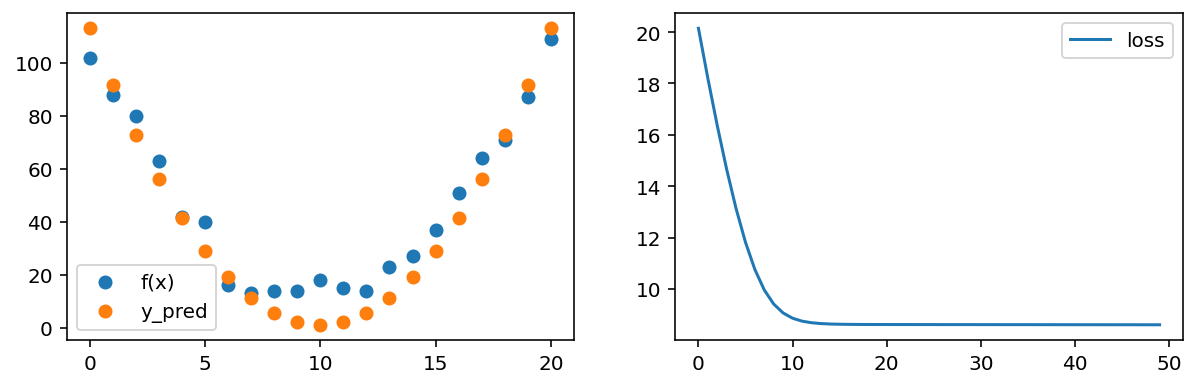

In [95]:
## too small learning rate
pred_params, track_loss = train(x, y_true, len(params), f, epochs=50, lr=10e-5)
y_pred = f(x, pred_params.data)
train_plot(x, y_true, y_pred, track_loss)

## larger value is better
pred_params, track_loss = train(x, y_true, len(params), f, epochs=50, lr=0.001)
y_pred = f(x, pred_params.data)
train_plot(x, y_true, y_pred, track_loss)

## parabol with 3 random parameters

In [96]:
np.random.seed(101)
torch.manual_seed(101)

In [97]:
def f2(x, params):
    a,b,c = params
    return a*(x-10)**2 + b*x + c

In [98]:
params = torch.randn(3) * 100
params

tensor([-139.0506,  -81.5238,  -32.0438])

<AxesSubplot:>

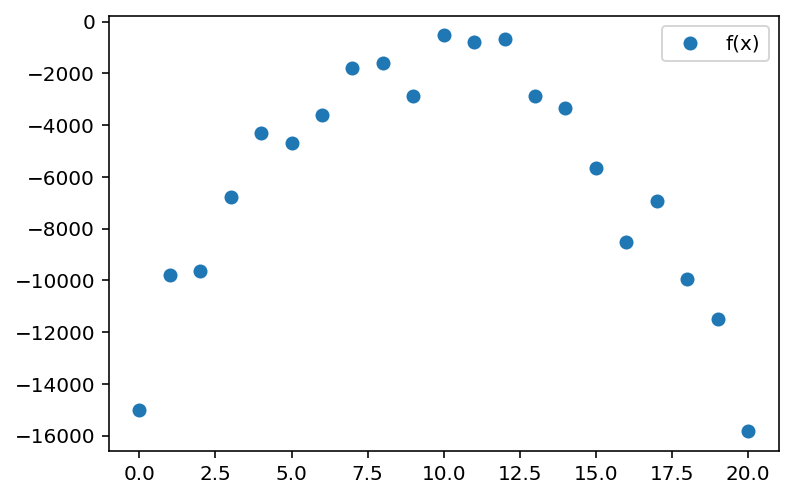

In [99]:
y_true = f2(x, params) + torch.randn_like(x)*1000
plot_func(x, y_true)

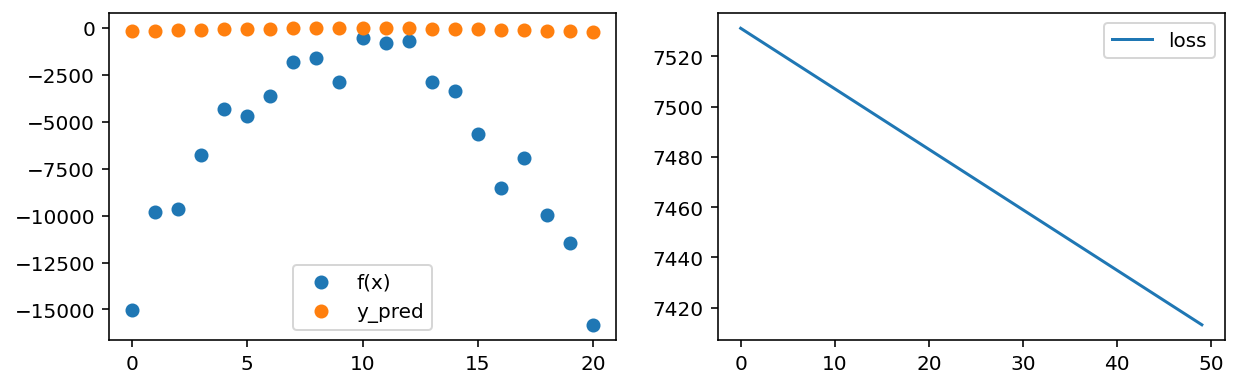

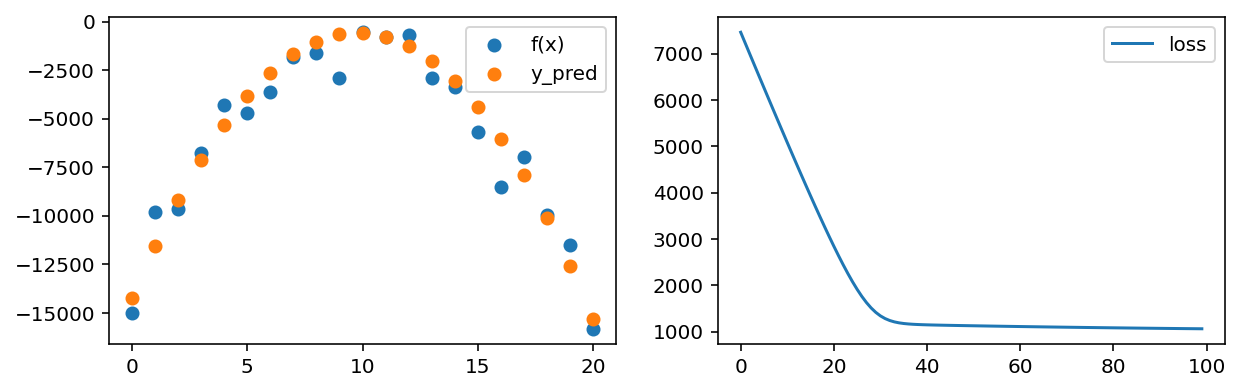

In [100]:
pred_params, track_loss = train(x, y_true, f=f2, n_params=params.shape[0], epochs=50, lr=0.001)
y_pred = f2(x, pred_params.data)
train_plot(x, y_true, y_pred, track_loss)

pred_params, track_loss = train(x, y_true, f=f2, n_params=params.shape[0], epochs=100, lr=0.1)
y_pred = f2(x, pred_params.data)
train_plot(x, y_true, y_pred, track_loss)

# SDG for binary MNIST (3-vs-7)

In [101]:
np.random.seed(42)
torch.manual_seed(42)

In [102]:
def dataprep(d_images, first_class, second_class):
    batch_x = []
    batch_y = []
    
    for idx, digit in enumerate((first_class, second_class)):
        X = torch.tensor(np.array(d_images[digit]), dtype=torch.float).view(-1, 28*28)
        X /= 255
        y = torch.zeros(X.shape[0], 1) + idx
        batch_x.append(X)
        batch_y.append(y)
    
    return torch.cat(batch_x), torch.cat(batch_y)

In [103]:
train_x, train_y = dataprep(d_images, first_class=3, second_class=7)
val_x, val_y = dataprep(d_images_val, first_class=3, second_class=7)

In [104]:
def train(train_loader, val_loader, lr=0.01, epochs=10):
    weights = torch.randn(28*28, requires_grad=True)
    bias = torch.randn(1, requires_grad=True)

    track_loss = []
    track_acc = []

    for _ in range(epochs):

        for x, y in train_loader:
            loss = (x @ weights + bias).sigmoid()
            loss = torch.where(y.squeeze()==0, 1-loss, loss)
            loss = loss.mean()

            loss.backward()

            weights.data -= lr * weights.grad.data
            bias.data -= lr * bias.grad.data
            weights.grad.zero_()
            bias.grad.zero_()

            track_loss.append(loss.item())

            # NOTE: it is overkilling doing it for every mini batch
            with torch.no_grad():
                acc = 0
                samples = 0

                for x, y in val_loader:
                    loss = (x @ weights + bias).sigmoid()

                    y_pred = torch.where(loss > 0.5, 0, 1)
                    acc += (y.squeeze() == y_pred).sum().item()
                    samples += x.shape[0]

                track_acc.append(acc / samples)
                
            
    return track_loss, track_acc, (weights, bias)

## Note: random generator seed

Following the suggestion posted here [https://forums.fast.ai/t/solved-reproducibility-where-is-the-randomness-coming-in/31628/4](https://forums.fast.ai/t/solved-reproducibility-where-is-the-randomness-coming-in/31628/4), to set the random seed we need to set
```
np.random.seed()
torch.manual_seel()
random.seed()
```

In [105]:
def init_random_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    random.seed(seed)

## Note: impact of `lr` and `shuffle=True`

The book adopts two subtle choices:
1. `lr=1.` which is an unconventional choice with respect to literature but has __STRONG IMPACT__ on the results, as it speed up convergence 
2. `dl = DataLoader(dset, batch_size=256)` which means __NO SHUFFLE!__ as the default is `shuffle=False`. Again, this has __STRONG IMPACT__ and justifies the saber-tooth/square-gate of the loss---each epoch starts by optimizing the model to classify 3s, so the loss shoots when starts encoutering 7s 

By enabling shuffling 
- the behavior described in (2) is mitigated
- the training is still subject to the learning rate but converges faster

In [106]:
def get_loaders(train_x, train_y, val_x, val_y, batch_size=256, seed=42, shuffle_train=True):
    init_random_seed(seed)
    
    train_loader = DataLoader(list(zip(train_x, train_y)), bs=batch_size, shuffle=shuffle_train)
    val_loader = DataLoader(list(zip(val_x, val_y)), bs=batch_size, shuffle=False)

    return train_loader, val_loader

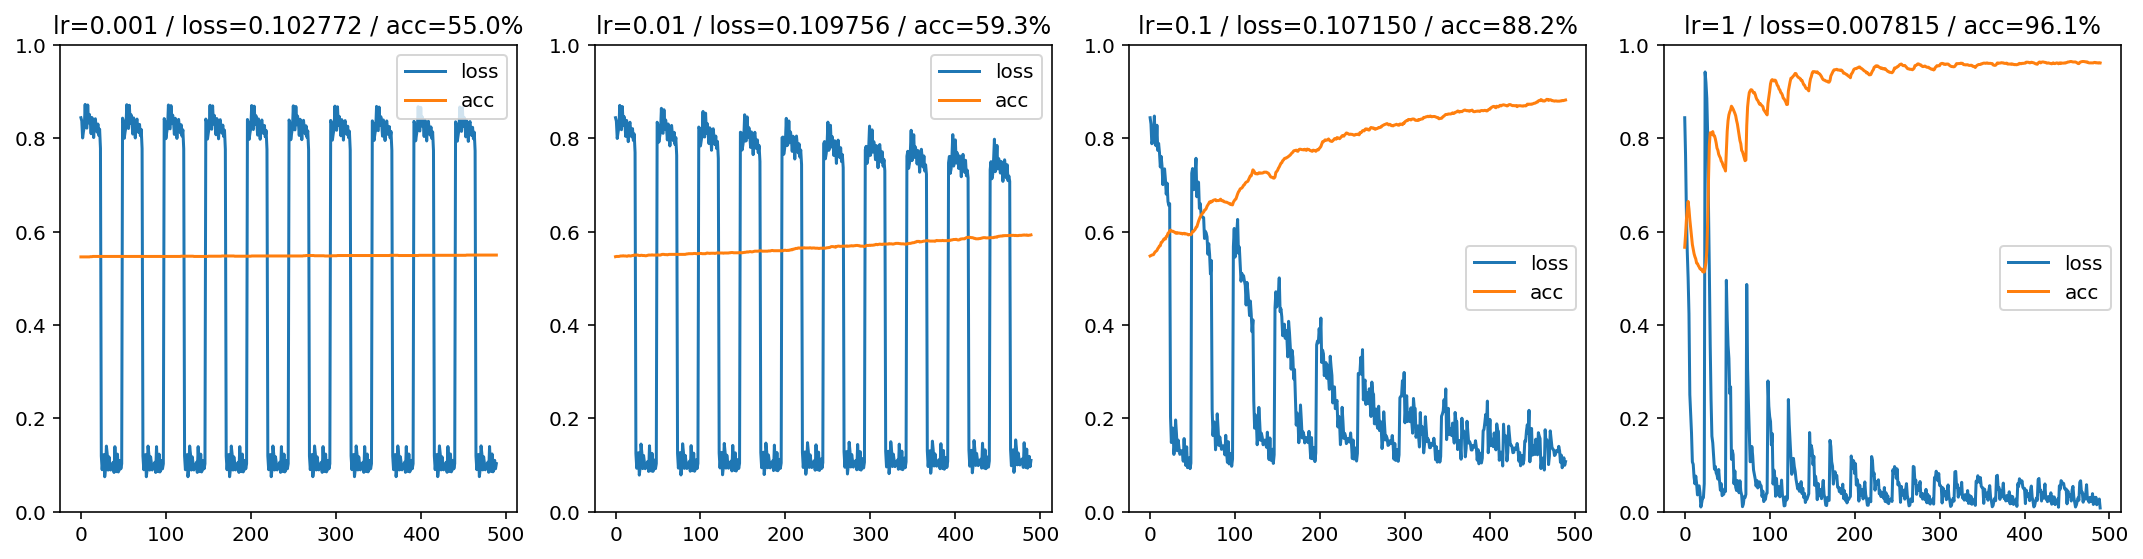

In [208]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(15,4))

for ax,lr in zip(axes, (0.001, 0.01, 0.1, 1)):

    train_loader, val_loader = get_loaders(train_x, train_y, val_x, val_y, shuffle_train=False)

    track_loss, track_acc, params = train(train_loader, val_loader, lr=lr, epochs=10)
    ax.plot(track_loss, label='loss')
    ax.plot(track_acc, label='acc')
    ax.set_title(f'lr={lr} / loss={track_loss[-1]:.6f} / acc={track_acc[-1]*100:.1f}%')
    ax.legend()
    ax.set_ylim(0, 1)
    
plt.tight_layout()

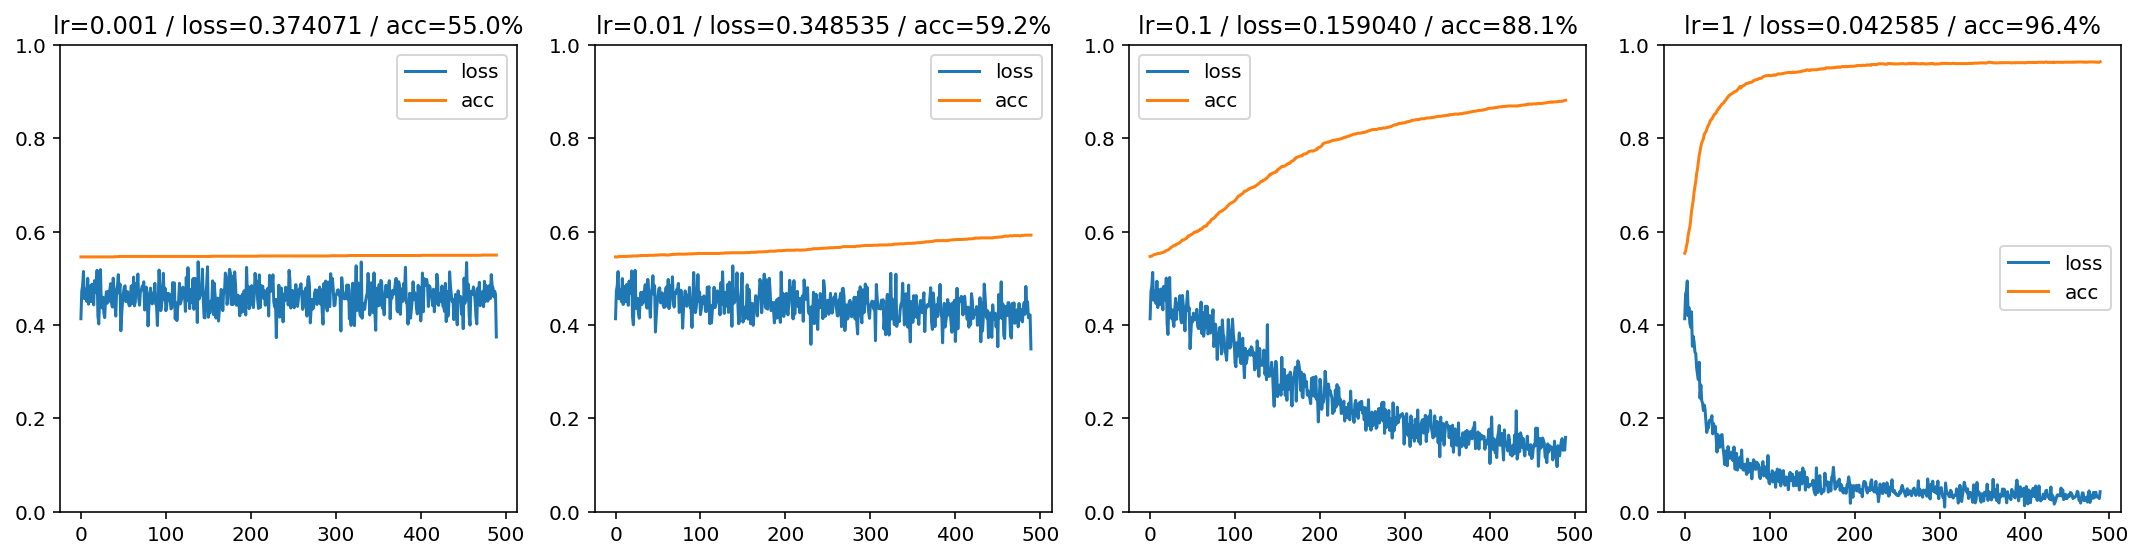

In [209]:
# repeat the same as above, but shuffling the training set

train_loader = DataLoader(list(zip(train_x, train_y)), bs=256, shuffle=True)
val_loader = DataLoader(list(zip(val_x, val_y)), bs=256, shuffle=False)

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(15,4))

for ax,lr in zip(axes, (0.001, 0.01, 0.1, 1)):
    
    train_loader, val_loader = get_loaders(train_x, train_y, val_x, val_y, shuffle_train=True)
    
    track_loss, track_acc, params = train(train_loader, val_loader, lr=lr, epochs=10)
    ax.plot(track_loss, label='loss')
    ax.plot(track_acc, label='acc')
    ax.set_title(f'lr={lr} / loss={track_loss[-1]:.6f} / acc={track_acc[-1]*100:.1f}%')
    ax.legend()
    ax.set_ylim(0, 1)
    
plt.tight_layout()

## refactoring the previous code

In [210]:
def randn_params(*size):
    return torch.randn(size, requires_grad=True)

def predict(x, *params):
    weights, bias = params
    return (x@weights + bias).sigmoid()

def compute_loss(y_pred, y_true):
    loss = torch.where(y_true == 0, 1-y_pred, y_pred)
    return loss.mean()

def update_gradient(lr, *params):
    for par in params:
        par.data -= lr * par.grad
        par.grad = None
    return params

def train_step(y_true, y_pred, lr, *params):
    loss = compute_loss(y_pred, y_true)
    loss.backward()
    params = update_gradient(lr, *params)
    return loss.item()

def compute_accuracy(y_pred, y_true):
    labels = torch.where(y_pred > 0.5, 0, 1)
    return (labels == y_true).sum().item()

def validate(loader, *params):
    with torch.no_grad():
        correct = 0
        samples = 0
        for x, y_true in loader:
            y_pred = predict(x, *params)
            correct += compute_accuracy(y_pred, y_true)
            samples += x.shape[0]
    return correct/samples

def fit(train_loader, val_loader, epochs, lr, *params):
    metric_loss = []
    metric_acc = []
    
    for _ in range(epochs):
        for x, y_true in train_loader:
            y_pred = predict(x, *params)
            loss = train_step(y_true, y_pred, lr, *params)
            metric_loss.append(loss)

            metric_acc.append(validate(val_loader, *params))
    return metric_loss, metric_acc

## Note: overall mean, and mean of a mini-batch mean

To validate, the book computes the average accuracy per mini-back, and average those over one epoch, i.e., it computes A MEAN OF A MEAN...which is not the actual mean per epoch

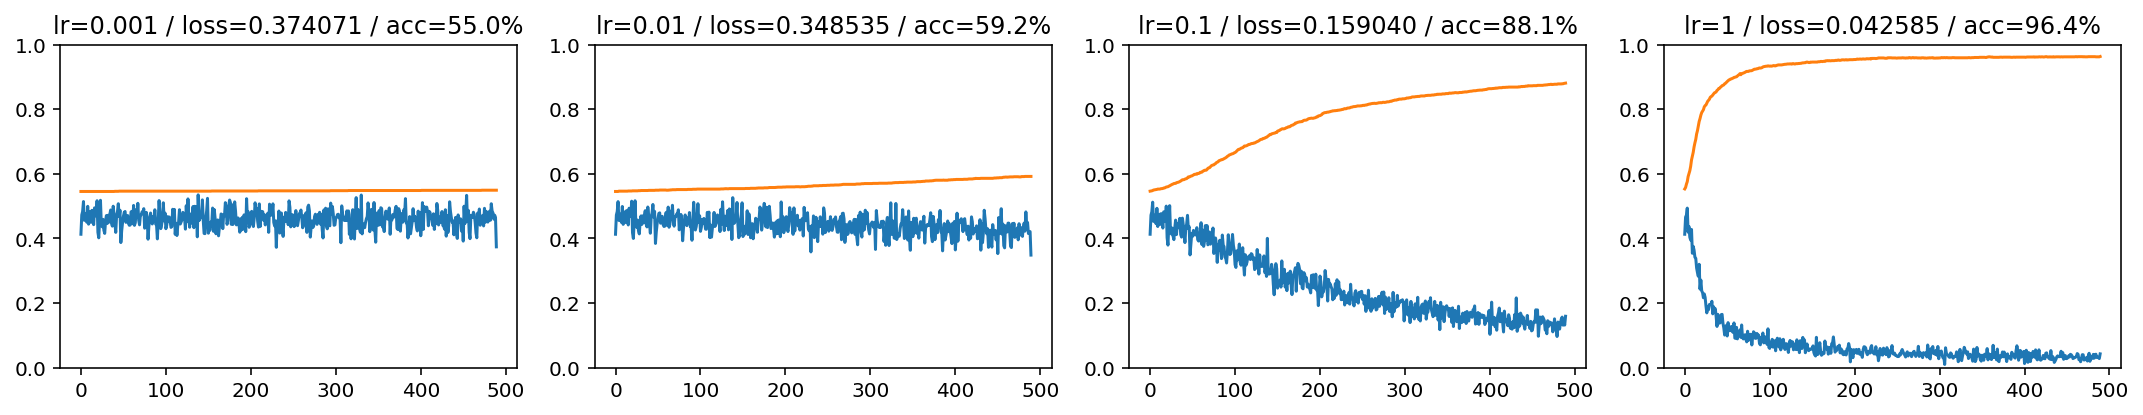

In [211]:
## this is just refactoring of previous code
## results are the same as before

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(15,3))

for ax, lr in zip(axes, (0.001, 0.01, 0.1, 1)):
    
    train_loader, val_loader = get_loaders(train_x, train_y, val_x, val_y, shuffle_train=True)
    
    weights = randn_params(28*28, 1)
    bias = randn_params(1)
    params = (weights, bias)
    epochs = 10

    metric_loss, metric_acc = fit(train_loader, val_loader, epochs, lr, *params)
    ax.plot(metric_loss, label='loss')
    ax.plot(metric_acc, label='acc')
    ax.set_title(f'lr={lr} / loss={metric_loss[-1]:.6f} / acc={metric_acc[-1]*100:.1f}%')
    ax.set_ylim(0, 1)
    
plt.tight_layout()

## Adding an `Optimizer` class

In [214]:
class Optimizer:
    def __init__(self, params, lr):
        self.parameters = self.init_params(params)
        self.lr = lr
    
    def init_params(self, params):
        for p in params:
            p.data = torch.randn_like(p)
            p.requires_grad_()
        return params
    
    def zero_grad(self):
        for p in self.parameters:
            p.grad = None
            
    def step(self):
        for p in self.parameters:
            p.data -= self.lr * p.grad

In [215]:
def train_step(y_true, y_pred, lr, optimizer):
    loss = compute_loss(y_pred, y_true)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss.item()

def fit(train_loader, val_loader, epochs, lr, optimizer, *params):
    metric_loss = []
    metric_acc = []
    
    for _ in range(epochs):
        for x, y_true in train_loader:
            y_pred = predict(x, *params)
            loss = train_step(y_true, y_pred, lr, optimizer)
            metric_loss.append(loss)
            metric_acc.append(validate(val_loader, *params))
    return metric_loss, metric_acc

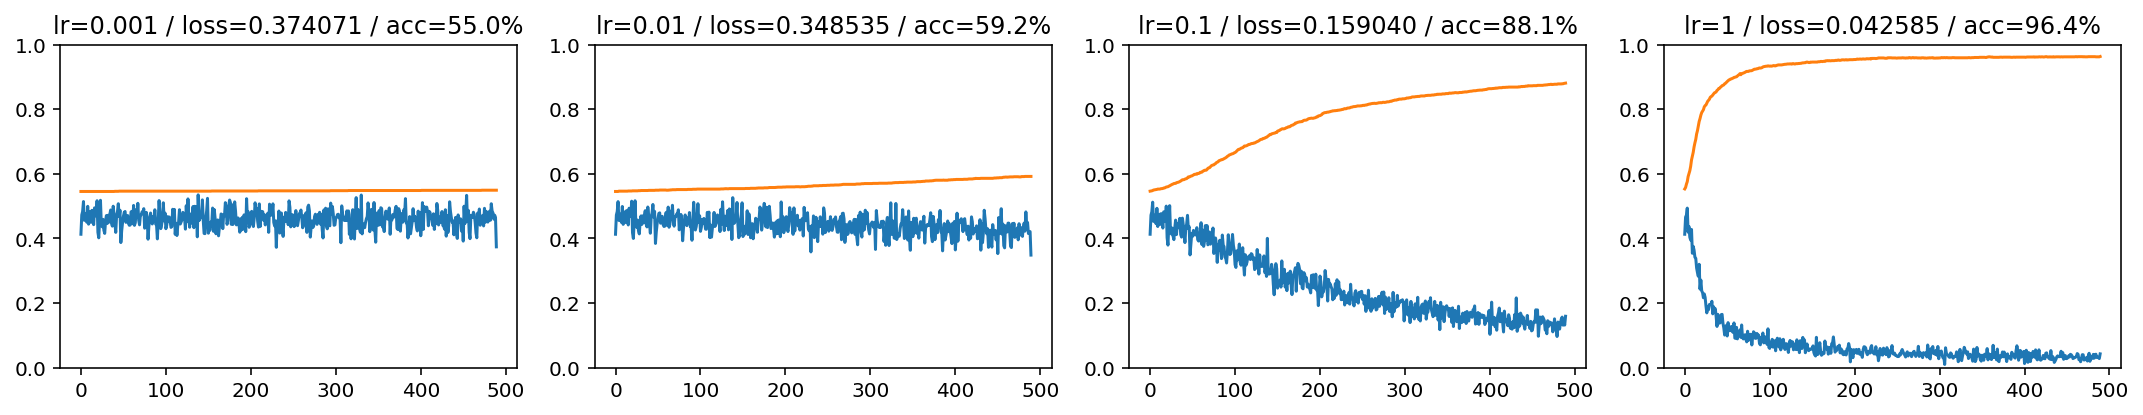

In [216]:
## again, this is just refactoring
## so results are the same as before

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(15,3))

for ax, lr in zip(axes, (0.001, 0.01, 0.1, 1)):
    train_loader, val_loader = get_loaders(train_x, train_y, val_x, val_y, shuffle_train=True)
    
    # Optimizer will randomly init the params
    # so we can set them to zero for now
    params = (
        torch.zeros(28*28, 1),
        torch.zeros(1),
    )
    optim = Optimizer(params, lr=lr)

    metric_loss, metric_acc = fit(train_loader, val_loader, 10, lr, optim, *params)
    
    ax.plot(metric_loss, label='loss')
    ax.plot(metric_acc, label='acc')
    ax.set_ylim(0, 1)
    ax.set_title(f'lr={lr} / loss={metric_loss[-1]:.6f} / acc={metric_acc[-1]*100:.1f}%')

plt.tight_layout()

## Creating a 2-layers model

In [217]:
def get_linear(in_size, out_size):
    w = torch.zeros(in_size, out_size)
    b = torch.zeros(out_size)    
    return w, b

def predict(x, *params):
    for idx, (w, b) in enumerate(params, start=1):
        x = (x@w + b)
        if idx < len(params):
            x = torch.max(x, torch.zeros_like(x))
    return x.sigmoid()

In [218]:
class MultilayersOptimizer:
    def __init__(self, params, lr):
        self.parameters = self.init_params(params)
        self.lr = lr
    
    def init_params(self, params):
        for layer_params in params:
            for p in layer_params:
                p.data = torch.randn_like(p)
                p.requires_grad_()
        return params
    
    def zero_grad(self):
        for layer_params in self.parameters:
            for p in layer_params:
                p.grad = None
            
    def step(self):
        for layer_params in self.parameters:
            for p in layer_params:
                p.data -= self.lr * p.grad

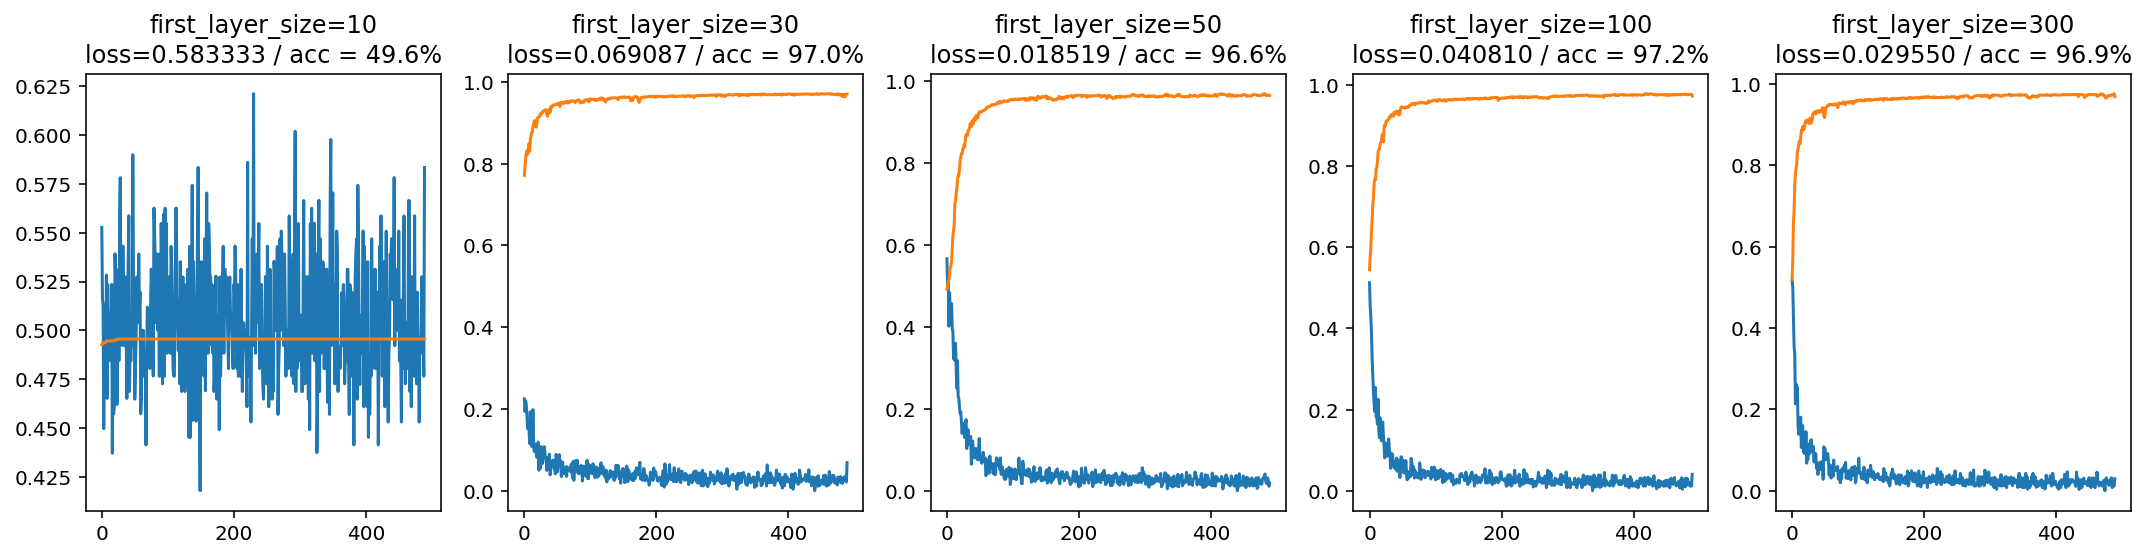

In [226]:
FIRST_LAYER_SIZES = (10, 30, 50, 100, 300)
LR = 1
EPOCHS = 10

fig, axes = plt.subplots(nrows=1, ncols=len(FIRST_LAYER_SIZES), figsize=(15, 4))

for ax, first_layer_size in zip(axes, FIRST_LAYER_SIZES):
    
    train_loader, val_loader = get_loaders(train_x, train_y, val_x, val_y, shuffle_train=True)

    params = (
        get_linear(28*28, first_layer_size),
        get_linear(first_layer_size, 1)
    )
    optimizer = MultilayersOptimizer(params, lr=LR)
    metric_loss, metric_acc = fit(train_loader, val_loader, EPOCHS, LR, optimizer, *params)
    
    ax.plot(metric_loss, label='loss')
    ax.plot(metric_acc, label='acc')
    ax.set_title(f'first_layer_size={first_layer_size}\nloss={metric_loss[-1]:.6f} / acc = {metric_acc[-1]*100:.1f}%')
    
plt.tight_layout()

## Creating a 3-layers model

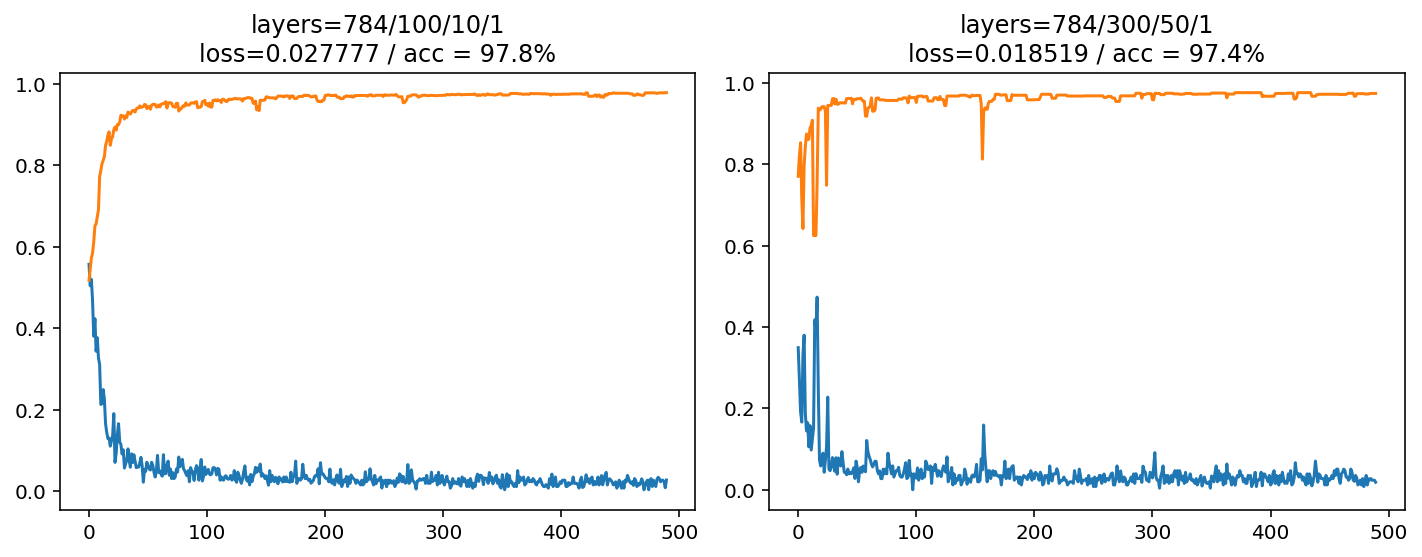

In [228]:
MULTI_LAYER_SIZES = ((100, 10), (300, 50))
LR = 1
EPOCHS = 10

fig, axes = plt.subplots(nrows=1, ncols=len(MULTI_LAYER_SIZES), figsize=(10, 4))

for ax, layer_sizes in zip(axes, MULTI_LAYER_SIZES):
    
    train_loader, val_loader = get_loaders(train_x, train_y, val_x, val_y, shuffle_train=True)

    layer_sizes = [28*28] + list(layer_sizes) + [1]
    params = []
    for idx in range(len(layer_sizes)-1):
        params.append(get_linear(layer_sizes[idx], layer_sizes[idx+1]))
    optimizer = MultilayersOptimizer(params, lr=LR)
    metric_loss, metric_acc = fit(train_loader, val_loader, EPOCHS, LR, optimizer, *params)
    
    ax.plot(metric_loss, label='loss')
    ax.plot(metric_acc, label='acc')
    ax.set_title(f'layers={"/".join(map(str, layer_sizes))}\n'
                 f'loss={metric_loss[-1]:.6f} / acc = {metric_acc[-1]*100:.1f}%')
    
plt.tight_layout()